In [1]:
import pandas as pd
import seaborn as sns
import missingno as msgo
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.decomposition import PCA
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,\
                            recall_score, ConfusionMatrixDisplay, classification_report,\
                            roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score,\
                                     StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

### Análisis exploratorio de datos:
El objetivo de este proyecto es construir un modelo de aprendizaje automático que pueda predecir si un paciente tiene diabetes o no. Para ello, contamos con un conjunto de datos que contiene información valiosa sobre diferentes características de salud de los pacientes. Empezamos con la carga de datos y un pequeño análisis exploratorio:

In [2]:
df = pd.read_csv('diabetes_prediction_dataset_train-labeled.csv')

In [3]:
df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0


###  Veamos si los tipos de los datos estan correctos:

In [4]:
df.dtypes

patient                  int64
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

***Los tipos estan bien***

### Consultemos faltantes:

<Axes: >

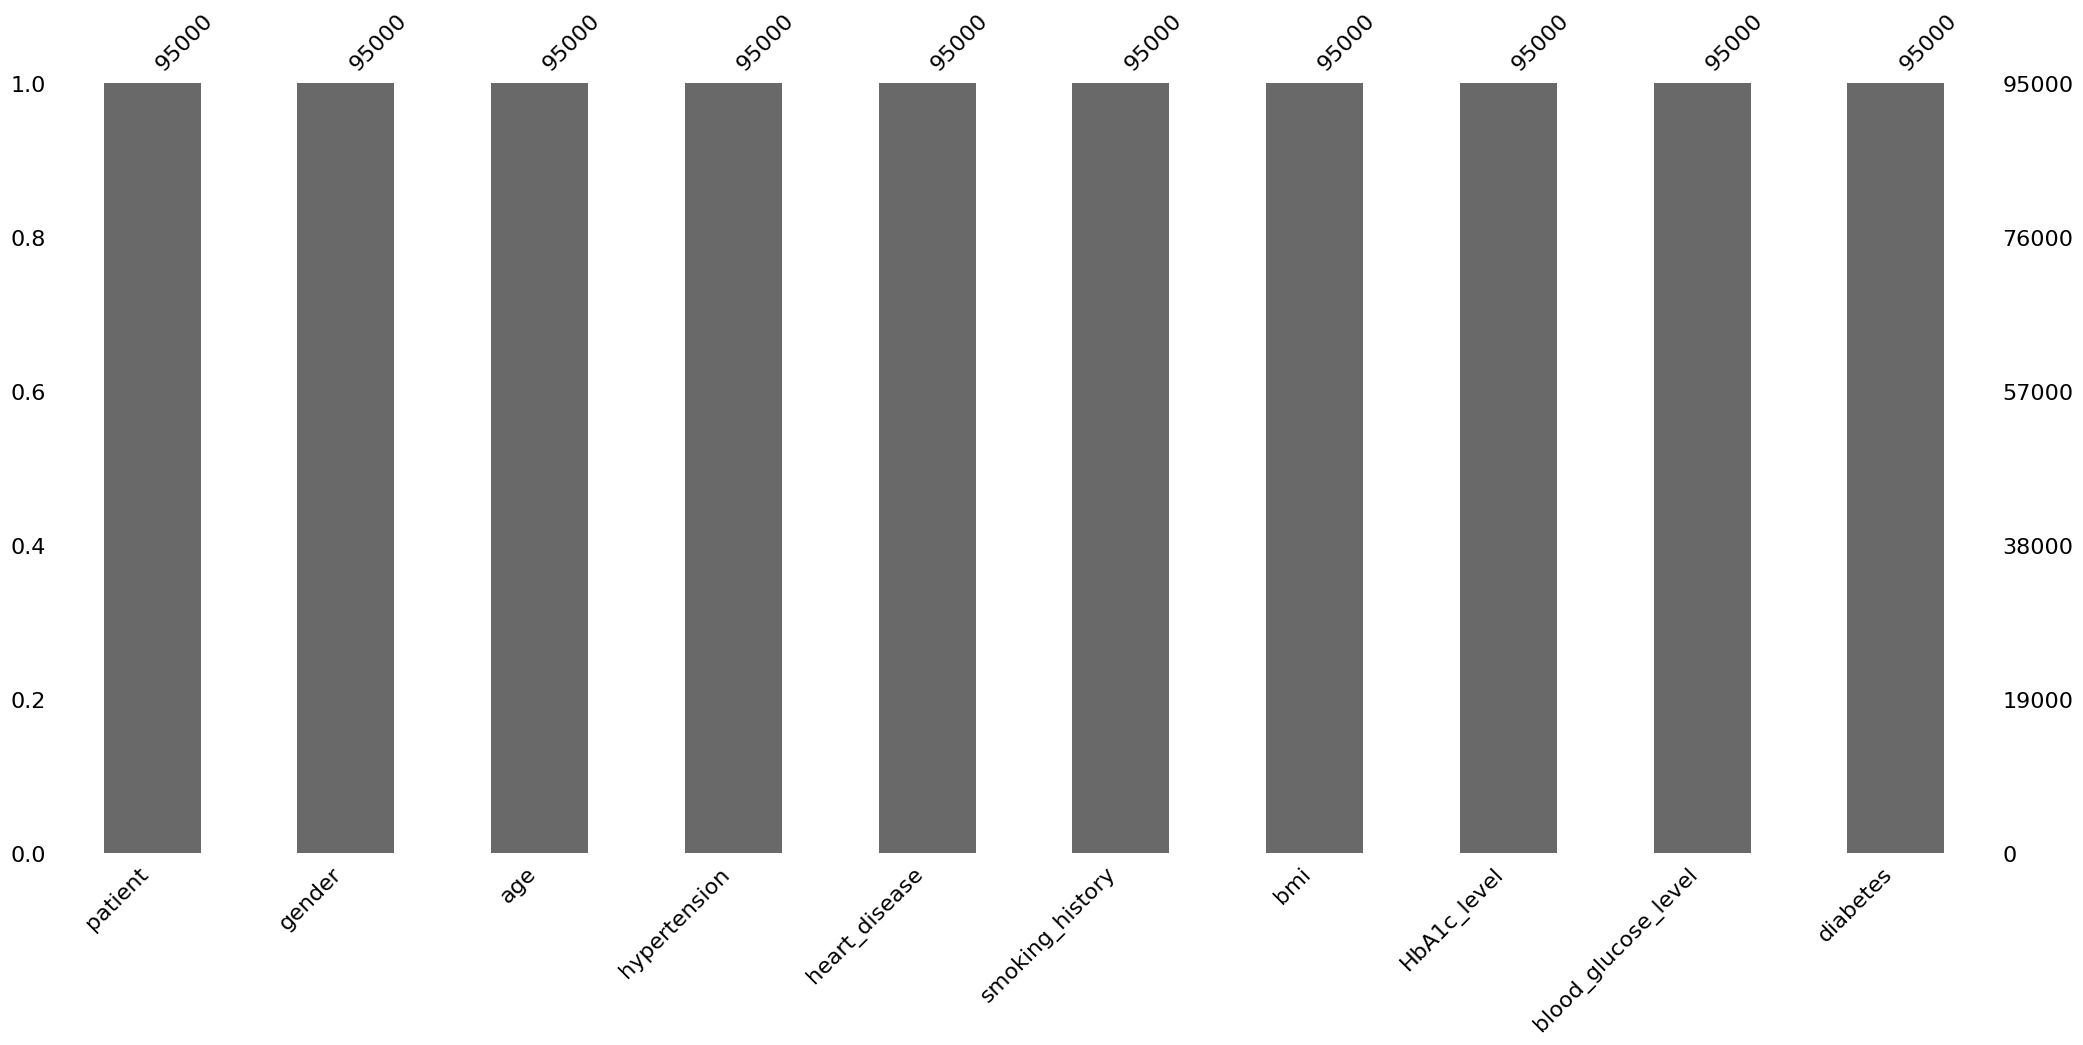

In [5]:
msgo.bar(df)

### Observemos los datos numericos:

In [6]:
numeric_columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'patient']

In [7]:
df[numeric_columns].describe(include="all")

,age,bmi,HbA1c_level,blood_glucose_level,patient
count,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000
mean,41.935269,27.320879,5.527659,138.070537,50016.501389
std,22.514788,6.626335,1.070261,40.739962,28868.357071
min,0.080000,10.010000,3.500000,80.000000,1.000000
25%,24.000000,23.650000,4.800000,100.000000,25021.750000
50%,43.000000,27.320000,5.800000,140.000000,50024.000000
75%,60.000000,29.580000,6.200000,159.000000,75024.250000
max,80.000000,95.690000,9.000000,300.000000,100000.000000


Vemos que nuestros datos numericos tiene diferentes rangos, por lo que es necesario estandarizarlos. Ademas eliminaremos la columna patient ya que no brinda ninguna informacion.

In [8]:
df.drop(columns=['patient'], inplace=True)

### Observemos nuestros datos categoricos no codificados:

In [9]:
categorical_columns = ['smoking_history', 'gender']
df[categorical_columns].describe(include='all')

,smoking_history,gender
count,95000,95000
unique,6,3
top,No Info,Female
freq,33958,55563


Utilizaremos un One Hot Encoder para las variables en vez de un LabelEncoder, para las columnas no codificadas, debido a que este ultimo nos podria introducir ordinalidad en los datos, generando una relacion donde no la hay.

### Ahora observamos si nuestra columna target presenta desiquilibrios entre clases:

In [10]:
class_counts = df['diabetes'].value_counts()
print(class_counts)

0    86918
1     8082
Name: diabetes, dtype: int64


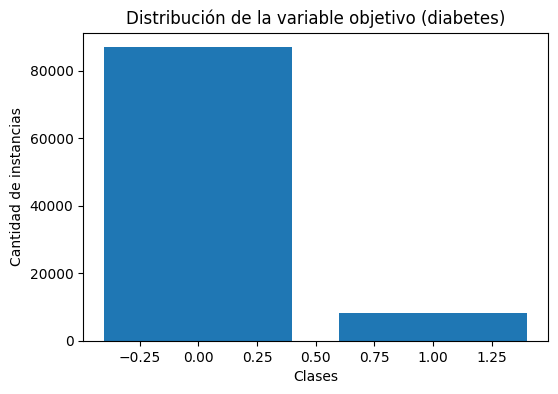

In [11]:
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clases')
plt.ylabel('Cantidad de instancias')
plt.title('Distribución de la variable objetivo (diabetes)')
plt.show()

Podemos observar que existe un desequilibrio significativo entre las clases de la variable objetivo. La clase "No diabetes" (clase 0) tiene muchas más instancias que la clase "Diabetes" (clase 1). Esta diferencia en la cantidad de muestras entre las clases puede tener un impacto negativo en el rendimiento del modelo de predicción de diabetes.

Este desequilibrio puede llevar a una alta precisión en la clase mayoritaria, pero una baja precisión y recall en la clase minoritaria. Por lo tanto, es probable que el modelo tenga dificultades para identificar correctamente los casos de diabetes, que son de mayor interés en este contexto.

Para abordar este problema entrenaremos modelos que funcionan mejor para datasets de esta índole. Entre ellos se encuentran a todos los basados en árboles de decisión o aquellos algoritmos de boosting (XGBoost, AdaBoosting), dado que estos últimos le ponen mayor peso a la clase minoritaria por cada iteración. Además, en los distintos modelos incluiremos distintos parámetros de la variable "class_weight" para poder abordar este problema.

En conclusión, realizaremos el escalado de características numéricas para homogeneizar sus rangos y la codificación one-hot de características categóricas para convertirlas en variables numéricas. Con estas transformaciones esperamos optimizar el rendimiento de los modelos a testear

## Preprocesamiento y curación de datos:
#### Codifiquemos las variables categoricas:

In [12]:
# Creamos el encoder
ohe = OneHotEncoder()

# Codificamos las columnas categoricas
enc_data = pd.DataFrame(ohe.fit_transform(df[categorical_columns]).toarray())

# Cambiamos los nombres de las columas
ohe.get_feature_names_out()
enc_data.columns = ohe.get_feature_names_out()
enc_data

,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,gender_Female,gender_Male,gender_Other
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
94995,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
94996,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
94997,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
94998,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
#Agregamos las columnas al dataframe
df_encoded = df.copy()
df_encoded.drop(columns=categorical_columns, inplace=True) # Eliminamos las columnas originales
df_encoded = df_encoded.join(enc_data) # Agregamos la codificacion

In [14]:
df_encoded.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'smoking_history_No Info',
       'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_not current', 'gender_Female', 'gender_Male',
       'gender_Other'],
      dtype='object')

#### Ahora que tenemos nuestros datos codificados, revisemos las correlaciones:

In [15]:
corr = df_encoded.corrwith(df_encoded['diabetes'])
corr.sort_values().tail(10)

smoking_history_never     0.026749
gender_Male               0.037929
smoking_history_former    0.098988
heart_disease             0.172485
hypertension              0.197198
bmi                       0.214126
age                       0.257818
HbA1c_level               0.399854
blood_glucose_level       0.420650
diabetes                  1.000000
dtype: float64

In [16]:
corr.sort_values().head(5)

smoking_history_No Info       -0.118243
gender_Female                 -0.037822
gender_Other                  -0.003958
smoking_history_current        0.019314
smoking_history_not current    0.019901
dtype: float64

Vemos que las variables con mas correlacion con el target son:

* blood_glucose_level
* HbA1c_level
* age
* bmi
* hypertension
* heart_desease

#### Estandarizamos los datos:

In [17]:
y = df_encoded.diabetes  #df_encoded.diabetes# Sacamos nuestra variable target de los datos
#X = df_encoded[['blood_glucose_level_dagerous', 'HbA1c_level_dagerous',
#                'blood_glucose_level','HbA1c_level']]

X = df_encoded.drop(columns=['diabetes'])

# Estandarizamos los datos:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Con los datos ya curados, realizamos la división de los datos en conjuntos de entrenamiento y prueba antes de entrenar y evaluar los modelos:

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state = 42)

</br>

## Modelos con mas accuracy conseguidos:

## XGboost:

In [19]:
# Instanciamos nuestro modelo con regresion logistica.
xgb_model_best_acc = xgb.XGBClassifier(
    objective="binary:logistic",
    max_depth = 12,
    n_estimators = 105,
    learning_rate = 0.01,
    #scale_pos_weight = 1.2,
    min_child_weight = 15,
)

xgb_model_best_acc.fit(x_train, y_train)
y_pred_tunned = xgb_model_best_acc.predict(x_test)

y_train_pred_best_acc = xgb_model_best_acc.predict(x_train)
accuracy = accuracy_score(y_train, y_train_pred_best_acc)
print("Accuracy_train:", accuracy)
y_pred_best_acc = xgb_model_best_acc.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_best_acc)
print("Accuracy_test:", accuracy)

Accuracy_train: 0.9722368421052632
Accuracy_test: 0.972


In [20]:
cv_array_xgboost = cross_val_score(xgb_model_best_acc, X_scaled, y, cv=10, scoring='accuracy')
cv_array_xgboost

array([0.97084211, 0.97210526, 0.97357895, 0.97178947, 0.97010526,
       0.97378947, 0.97073684, 0.97621053, 0.97052632, 0.97      ])

In [32]:
cv_array_xgboost.mean()

0.9719684210526317

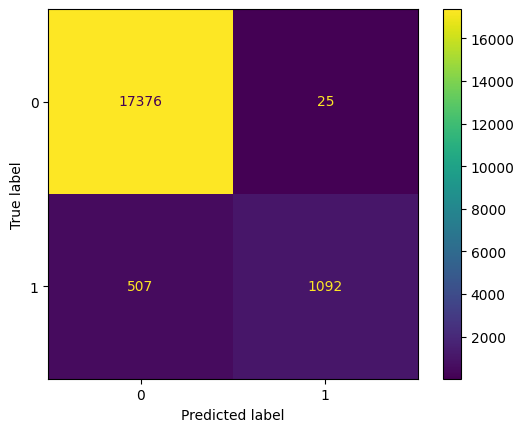

In [22]:
cm = confusion_matrix(y_test, y_pred_best_acc)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## GradientBoost:

In [30]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(x_train,y_train)
y_train_pred_gb_model = gb_model.predict(x_train)
accuracy = accuracy_score(y_train, y_train_pred_gb_model)
print("Accuracy_train:", accuracy)
y_pred_gb_model = gb_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_gb_model)
print("Accuracy_test:", accuracy)


Accuracy_train: 0.9721973684210526
Accuracy_test: 0.9720526315789474


### Ajuste hiperparametros:

In [31]:
param_dist_gb = {
    'n_estimators': randint(100, 500),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}
# Randomized Search para Gradient Boosting
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist_gb, cv=5,
                                      scoring='accuracy', random_state=42, n_jobs=-1)
random_search_gb.fit(x_train, y_train)
random_search_gb.best_params_

{'learning_rate': 0.01,
 'max_depth': 9,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 413}

In [23]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01,
                                          max_depth=9,
                                          max_features='log2',
                                          min_samples_leaf=5,
                                           min_samples_split=2,
                                          n_estimators=413,
                                          random_state=42)
best_gb_model.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=9, max_features='log2',
                           min_samples_leaf=5, n_estimators=413,
                           random_state=42)

In [24]:
y_train_pred_gb_best = best_gb_model.predict(x_train)
accuracy = accuracy_score(y_train, y_train_pred_gb_best)
print("Accuracy_train:", accuracy)
y_pred_gb_best = best_gb_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_gb_best)
print("Accuracy_test:", accuracy)

Accuracy_train: 0.974421052631579
Accuracy_test: 0.9718947368421053


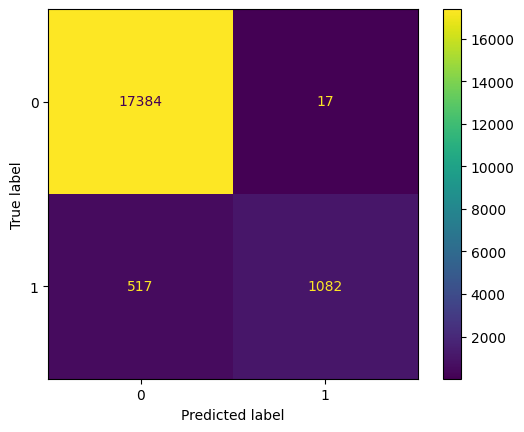

In [25]:
matrix = confusion_matrix(y_test, y_pred_gb_best)
ConfusionMatrixDisplay(confusion_matrix=matrix).plot();

## Random Forest:

In [33]:
rf2 = RandomForestClassifier(n_estimators=100,
                             min_samples_split=15, 
                             min_samples_leaf=7,
                             max_samples=0.33,
                             max_features='log2',
                             max_depth=20,
                             bootstrap=True)
rf2.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', max_samples=0.33,
                       min_samples_leaf=7, min_samples_split=15)

In [34]:
y_pred_2 = rf2.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy)

Accuracy: 0.9717368421052631


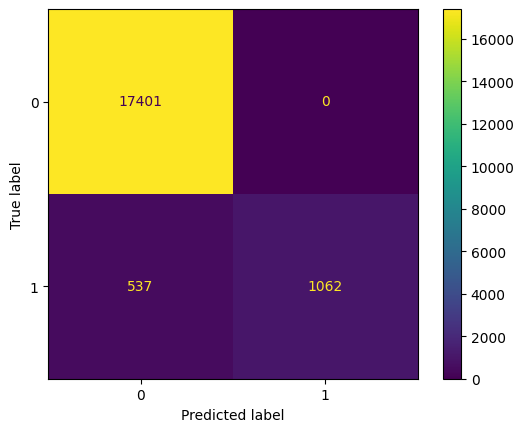

In [35]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_2)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

### Estos fueron los 3 modelos que mejor accuracy nos dieron en la competencia. Pero se realizaron un total de 9 modelos.

</br>

### Generamos la salida:

In [ ]:
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')
Y_test = test_df.diabetes
PatientId_test = test_df['patient']

In [ ]:
test_df.drop(columns=['patient'], inplace=True)
categorical_columns = ['smoking_history', 'gender']

In [ ]:
# Creamos el encoder
ohe = OneHotEncoder()

# Codificamos las columnas categoricas
enc_data = pd.DataFrame(ohe.fit_transform(test_df[categorical_columns]).toarray())

# Cambiamos los nombres de las columas
ohe.get_feature_names_out()
enc_data.columns = ohe.get_feature_names_out()
enc_data

In [ ]:
#Agregamos las columnas al dataframe
df_encoded = test_df.copy()
df_encoded.drop(columns=categorical_columns, inplace=True) # Eliminamos las columnas originales
df_encoded = df_encoded.join(enc_data) # Agregamos la codificacion

In [ ]:
"""
Donde tenemos MODEL_TO_TEST, debemos colocar el nombre del modelo que queremos que nos entregue las predicciones.

"""

test_id = PatientId_test
test_pred = MODEL_TO_TEST.predict(X_test)
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission_gb.csv", header=True, index=False)

</br>

</br>

# <center>Algunas ideas que se nos ocurrieron pero que no llegaron a resolver el problema:</center>

### Primera:

Por lo que pudimos observar de testear estos modelos y los demas realizados, es que teniamos un tope con respecto al accuracy que pudimos obtener. Como nuestro dataset, es un dataset desbalanceado. Intentamos mejorar el accuracy introduciendole el manejo de los pesos a los algoritmos, pero en la mayoria de los algoritmos nos disminuia mucho el accuracy en las pruebas de kaggle, a pesar de ser un mejor modelo a la hora de predecir. Se probo varias combinaciones de pesos, pero no se pudo bajar los False-Negative sin que los False-Positives aumenten mucho. Este desbalance, penaliza mas aquellas predicciones erroneas sobre la clase mayoritaria que sobre la minoritaria. 
Suponemos que para seguir mejorando el modelo hacia falta realizar alguna transformacion mas a los datos.

### Segunda:

En esta imagen (https://www.breathewellbeing.in/blog/wp-content/uploads/2021/03/shutterstock_1679494036.png)
encontramos que ciertos conjuntos de blood_glucose_level y HbA1c_level, determinan si una persona tiene o no diabetes. En base a esta tabla se intentaron agregar dos columnas explicitando cuando la persona tenga un numero dentro de lo necesario para diagnosticarle diabetes, se coloque 1 en la fila y sino un 0. La idea de esto, es poder generar una relacion nueva entre diabetes y las dos columnas nuevas, para ver si ayudaba a la hora de clasificar aquellas filas que tenian diabetes pero las clasificaba como que no.

Otra cosa que pudimos notar, es que si bien cumplian tanto el blood_glucose_level y HbA1c_level necesario para tener diabetes, en nuestros datos, la persona no tenia. No sabiamos si era o no un dato erroneo. Supusimos que no.

In [ ]:
def transform_value_Hba1c(value):
    if value >= 6.5:
        return 1
    else:
        return 0
    
def transform_value_blood(value):
    if value >= 145:
        return 1
    else:
        return 0

# Utilizamos el método apply para aplicar la función transform_value a cada elemento de la columna
df['HbA1c_level_dagerous'] = df['HbA1c_level'].apply(transform_value_Hba1c)
df['blood_glucose_level_dagerous'] = df['blood_glucose_level'].apply(transform_value_blood)

El problema de esto es que hay muchas filas que a pesar de tener valores que en nuestra tabla estan dentro de la diabetes, en nuestro dataset estan como no diabeticos. De igual manera esta idea no modifico nada el comportamiento de los modelos.

## Tercera:

Se tomo como opcion hacer Oversampling. Probamos con los modelos que mejor accuracy nos daban, y si bien a la hora del train y test parecian ser mejores modelos que los anteriores, cuando realizamos la pruebas en Kaggle, nuestro modelo tenia una pesima generalizacion, peor que aquellos modelos por default con los datos sin oversamplear.

No se probo evaluar nuestro modelo con undersampling en Kaggle. La matriz de confusion daba un 10% tanto de False-Negative como False-Positive. Pero viendo el resultado que tuvimos con el modelo con oversampling supusimos que este iba a dar un resultado similar.

## Cuarta:

Se probo realizar PCA para las variables. Nos dio como resultado que unos 13 componenetes nos explicaban el 100% de la varianza. Se entrenaron y testearon los modelos con estos datos. Pero el accuracy no se modificaba. 

</br>

### Como conclusion final, suponemos que para mejorar el modelo habria que haber hecho alguna transformacion a los datos que nos introduzca alguna relacion nueva. Que nos pueda diferenciar los casos que nuestros modelos no clasificaban bien.